<a href="https://colab.research.google.com/github/cmkstien/Myco_alpha/blob/main/PredictingDispersionCurves_December11th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Dispersion Curves Project v2.0**

A tool for predicting the type of behaviour of compounds during Differential Mobility Spectrometry (DMS).

See the instructions at the <a href="#Instructions"> bottom of the notebook </a>.

[Github link]

[LINK TO THE PAPER]

In [ ]:
%%capture
#@title Environment Settings { run: "auto" }

#@markdown Select whether or not you would like the anionic (negative) or cationic (positive) curve.
MS_Mode = "Positive Mode" #@param ["Positive Mode", "Negative Mode"]
#@markdown

#@markdown Select the DMS environment.
DMS_Environment = "N2" #@param ["MeOH", "N2"]
#@markdown

#@markdown Enter the SMILES of the molecules separated by **a single comma**.
SMILES = "c3cc2c(/C(c1c(cccc1)CC2)=C/CCNC)cc3"  #@param {type:"string"}
#@markdown

#@markdown Enter the number of model shuffle folds (different feature sets) you want to evaluate (each takes ~1 min).
num_seeds = 1  #@param {type:"raw"}

#@markdown Enter the name you would like your files to be saved with
job_name = 'test_cation_N2'  #@param {type:"string"}

#@markdown

#@markdown Now just hit `Runtime` -> `Run All`
#@markdown

#@markdown To save your predictions as a .csv file, click the following box

# Plot_Images = False #@param {type: "boolean"}
# Descriptor_Values = True #@param {type: "boolean"}
Predictions_results = True #@param {type: "boolean"}


In [ ]:
#@title Install Dependencies (~20s)
%%capture

!pip install shap
!pip install rdkit
!pip install tabulate
!pip install mordred
!pip install -U -q PyDrive

# Import statements
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, SGDRegressor
from sklearn.svm import SVR
import numpy as np
import pandas as pd
import scipy.stats as st
import rdkit
import logging
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import cv2
import random
import warnings
import time
import mordred
from tabulate import tabulate
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from mordred import Calculator, descriptors
from IPython.display import display
from os import X_OK
from google.colab import files


!wget https://raw.githubusercontent.com/Haisse/Predicting-Dispersion-Curves-Collab/refs/heads/main/100K_best_fits.json
!wget https://raw.githubusercontent.com/Haisse/Predicting-Dispersion-Curves-Collab/refs/heads/main/Normalized_Working_Descriptors_-1.csv
!wget https://raw.githubusercontent.com/Haisse/Predicting-Dispersion-Curves-Collab/refs/heads/main/Ionic%20SMILES%20Original.csv
!wget https://raw.githubusercontent.com/Haisse/Predicting-Dispersion-Curves-Collab/refs/heads/main/Top%20normalized%20model%20descriptors.txt
!wget https://raw.githubusercontent.com/Haisse/Predicting-Dispersion-Curves-Collab/refs/heads/main/Best%20Model%20Error%20Values.png


# Suppress warnings
warnings.filterwarnings("ignore")


In [ ]:
#@title Descriptor Calculator (~20s)
%%capture

# TO-DO: Add a check for if the molecule was trained on our database. Add the check immediately after input and retrieve the results from the file with experimental results.
# TO-DO: Fix and adjust dropping columns for where there are multiple molecules. Even if all necessary descriptors work, code breaks down if a column got removed with prior molecule.

# This code, given the list of SMILES strings allows to compute the descriptors in RDKit and mordred for given molecules.
# SMILES_address and json_address are file locations from which the program pulls data.
# output_address is file location and file format to which the program will save the results.
# normalise - boolean that when positively selected, has all the results be normalized using the cumulative distribution function.
# preserve_broken - boolean, that when positive , has the descriptors that did not pass tolerance check still appear in the final product but with "Broken" for values.

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

def Unified_Descriptor_Calculator(SMILES_input, normalise, preserve_broken):

    # Removes the SMILES that have less than 4 heavy atoms and do not contain carbon. Returns the list with those removed.
    def prune_SMILES(list_of_SMILES):
        Prunned_SMILES = []

        for i in range(0, len(list_of_SMILES)):
            mol = Chem.MolFromSmiles(list_of_SMILES[i])
            Chem.SanitizeMol(mol)
            Chem.Kekulize(mol)
            mol = Chem.MolToSmiles(mol, isomericSmiles=False)
            Prunned_SMILES.append(mol)

        return Prunned_SMILES

    # Removes the duplicate indeces that overlap between RDKit and mordred. It does it by comparing the full list of descriptors to list of RDKit Descriptors.
    # Returns the cleared list and also the list of duplicates that occured.
    def remove_mordred_duplicates(desc_list, RDKit_Descriptors):

        duplicate_indeces = []
        duplicates = []
        cleared_mordred_descriptors = list()

        for potential_duplicate in desc_list:
            if potential_duplicate in RDKit_Descriptors:

                dup_index = desc_list.index(potential_duplicate)
                duplicate_indeces.append(dup_index)
                duplicates.append(potential_duplicate)

            else:
                cleared_mordred_descriptors.append(potential_duplicate)

        return cleared_mordred_descriptors, duplicate_indeces

    # Creates a list of all descriptor names, for those defined by Cailum, RDKit and mordred. Returns final descriptor list, along with how many RDKit and how many mordred
    # descriptors there were in the final list and also showing any duplicates.
    def get_all_descriptor_names():
            """
            Get available descriptor names for RDKit and mordred physchem features. Custom subset can be used as list of ALL_descriptors.
            """
            cleared_mordred_descriptors = []
            len_mordred = 0
            len_RDKit = 0
            extra_header_list = ["aa", "a_prop", "t_order", "c_ar", "frac_C", "TPSA_2", "f_count", "oh_count", "cl_count", "amideB"]
            mordred_descriptors = Calculator(descriptors, ignore_3D=True).descriptors
            mordred_descriptors = (list(mordred_descriptors))
            for i in range(0, len(mordred_descriptors)):
                cleared_mordred_descriptors.append(str(mordred_descriptors[i]))

            rdkit_descriptors = [x[0] for x in Descriptors._descList]

            # Features that exist both in RDKit and mordred. Keep RDKit ones.
            cleared_mordred_descriptors, duplicate_indeces = remove_mordred_duplicates(cleared_mordred_descriptors, rdkit_descriptors)
            len_mordred = len(cleared_mordred_descriptors)
            len_RDKit = len(rdkit_descriptors)
            final_descriptors = extra_header_list
            final_descriptors.extend(rdkit_descriptors)
            final_descriptors.extend(cleared_mordred_descriptors)

            return final_descriptors, len_RDKit, len_mordred, duplicate_indeces

# Cailum's functions below
    def get_total_bond_order(SMILES):
        molecule = Chem.MolFromSmiles(SMILES)
        total_order = 0
        for bond in molecule.GetBonds():
            total_order += bond.GetBondTypeAsDouble()
        return total_order

    def carbon_anal(SMILES):
        molecule = Chem.MolFromSmiles(SMILES)
        total = 0
        c_count = 0
        c_ar = 0
        c_SP2 = 0
        f_count = 0
        cl_count = 0
        oh_count = 0
        for atom in molecule.GetAtoms():
            if atom.GetAtomicNum() == 6:
                c_count +=1
                if atom.GetIsAromatic():
                    c_ar +=1
                if atom.GetHybridization() == rdkit.Chem.rdchem.HybridizationType.SP2:
                    c_SP2 += 1
            if atom.GetAtomicNum() == 9:
                f_count +=1
            if atom.GetAtomicNum() == 17:
                cl_count +=1
            if atom.GetAtomicNum() == 8:
                if atom.GetTotalNumHs() == 1:
                    oh_count+=1
            total+=1

        frac_C = c_count / total
        return c_ar, frac_C, f_count, oh_count, cl_count

    def AromaticAtoms(molecule):
        aromatic_atoms = [molecule.GetAtomWithIdx(i).GetIsAromatic() for i in range(molecule.GetNumAtoms())]
        aa_count = []
        for i in aromatic_atoms:
            if i==True:
                aa_count.append(1)
        sum_aa_count = sum(aa_count)
        return sum_aa_count

    # Given a SMILES string, it calculates the descriptors defined by Cailum and returns them as a list.
    def Extra_descriptors_calculator(SMILE):
        extra_header_list = ["aa", "a_prop", "t_order", "c_ar", "frac_C", "TPSA_2", "f_count", "oh_count", "cl_count", "amideB"]

        try:
            c_ar, frac_C,f_count, oh_count, cl_count = carbon_anal(SMILE)

        except Exception as e:
            molecule = Chem.MolFromSmiles(SMILE)
            print("ERROR occured in - ", SMILE)

        molecule = Chem.MolFromSmiles(SMILE)

        ## Manual Calculation of Other Descriptors
        aa = AromaticAtoms(molecule)
        ha = Descriptors.HeavyAtomCount(molecule)
        Aromatic_prop = aa/ha
        a_prop = Aromatic_prop
        t_order =get_total_bond_order(SMILE)
        c_ar =c_ar
        c_frac = frac_C
        TPSA_2 =Descriptors.TPSA(molecule,includeSandP=True)
        F = f_count
        Oh = oh_count
        Cl = cl_count
        amideB = Chem.rdMolDescriptors.CalcNumAmideBonds(molecule)
        single_entry = [aa, a_prop, t_order, c_ar, c_frac, TPSA_2, F, Oh, Cl, amideB]
        return single_entry


    # Given the molecule (SMILES string) and the list of duplicate_indeces(to know which ones to skip), the function calculates all descriptors, Cailum's, RDKit and mordred
    # for a given SMILES.
    def calculate_descriptors(molecule, duplicate_indeces):
        SMILES = molecule

        try:
            molecule = Chem.MolFromSmiles(molecule)
        except Exception as e:
            # invalid?
            logging.warning(f'Chem.MolFromSmiles failed smiles="{molecule}" error={e}')
            return None

        if molecule is None:
            # invalid?
            logging.warning(f'Chem.MolFromSmiles failed smiles="{molecule}"')
            return None

        # Define calculators and calculate descriptors
        extra_desc_results = Extra_descriptors_calculator(SMILES)
        RDKit_results =  rdkit.Chem.Descriptors.CalcMolDescriptors(molecule, missingVal="Broken", silent=False)

        Mordred_calc = Calculator(descriptors, ignore_3D=True)
        mordred_results = Mordred_calc(molecule)

        RDKit_results = list(RDKit_results.values())
        mordred_results = list(mordred_results.values())

        for i in range(0, len(mordred_results)):
                if (type(mordred_results[i]) == mordred.error.Missing or type(mordred_results[i]) == mordred.error.Error):
                    mordred_results[i] = np.nan

        mordred_cleared_result = []

    # 4. Remove columns that are duplicates of RDKit descriptors in Mordred
        for i in range(0,len(mordred_results)):
            if i in duplicate_indeces:
                pass
            else:
                mordred_cleared_result.append(mordred_results[i])

        final_output = extra_desc_results
        final_output.extend(RDKit_results)
        final_output.extend(mordred_cleared_result)

        for i in range(0, len(final_output)):
            if np.isfinite(final_output[i]):
                final_output[i] = np.float64(final_output[i])

            else:
                final_output[i] = "Broken"

        return final_output

    # Function takes a frame of results that were previously calculated, along with list of descriptor names and tolerance percentage that defines the percentage of molecules
    # for which getting "Broken" value is acceptable. It then determines which columns are broken, removes them from results_frame and returns the modified results_frame.
    def remove_broken_columns(results_frame, descriptor_names):
        to_remove = list()
        columns_removed = 0


        for column_name in descriptor_names:
            single_column = results_frame[column_name].values

            for val in single_column:
                if val == "Broken":
                    to_remove.append(column_name)
                    columns_removed += 1

        for i in to_remove:
            descriptor_names.remove(i)

        results_frame = results_frame.drop(to_remove, axis=1)
        return results_frame

    # 4. Remove Broken elements while retaining the indeces inside of the single column
    def remove_Broken_and_store_positions(single_column):
        broken_indeces = list()
        column_of_values = list()

        for i in range(0, len(single_column)):
            if single_column[i] == "Broken":
                broken_indeces.append(i)
            else:
                column_of_values.append(np.float64(single_column[i]))

        return column_of_values, broken_indeces

    # Creates a column of "Broken" values and concatonates it to post_cdf_frame
    def add_broken_column(post_cdf_frame, SMILES_data):
        broken_list = ["Broken"] * len(SMILES_data)
        broken_frame = pd.DataFrame(broken_list, index=None, columns=[column_name])
        post_cdf_frame = pd.concat([post_cdf_frame, broken_frame], axis=1)
        return post_cdf_frame

    # This function rebuilds the whole column after cdf was applied to it. If it had entries with "Broken", those get readded at the same position. The final result is
    # concatenated to the final result frame, post_cdf_frame.
    def rebuild_entry(column_shape, cdf_results, post_cdf_frame):
                array_ind = 0
                for i in range(0, len(column_shape)):
                    if i in broken_indeces:
                        column_shape[i] = 'Broken'

                    else:
                        column_shape[i] = cdf_results[array_ind]
                        array_ind += 1

                column_frame = pd.DataFrame(column_shape, index=None, columns=[column_name])
                post_cdf_frame = pd.concat([post_cdf_frame, column_frame], axis=1)

                return post_cdf_frame

    # Main Code Structure:

    # 1. Declare end result frame
    results_frame = list()
    SMILES_input = SMILES_input.split(",")

    # 2. Load in the SMILES Strings
    # SMILES_strings = pd.read_csv(SMILES_list, header=None, encoding="latin1")
    # SMILES_data = np.array(SMILES_strings).flatten()
    # SMILES_frame = SMILES_data.copy()
    # SMILES_frame = pd.DataFrame(SMILES_frame, index=None, columns=["SMILES"])

    # 2. OPTIONAL, Prune the SMILES - Ask Cailum if we want to keep that
    prunned_SMILES = prune_SMILES(SMILES_input)
    SMILES_data = prunned_SMILES

    # 3. Set up the descriptor names to use. At the same time, record indeces of duplicate descriptors in mordred that are to
    #    be removed from final calculations.
    all_descriptors_output = get_all_descriptor_names()
    descriptor_names = all_descriptors_output[0]
    duplicate_indeces = all_descriptors_output[3]

    # 4. Convert to molecule object and calculate all descriptors. Add result to main frame.
    i = 0
    for single_SMILES in SMILES_data:
        if i % 1000 == 0:
            print(i)
        results_frame.append(calculate_descriptors(single_SMILES, duplicate_indeces))
        i+=1

    # Initial result of calculation of all descriptors. If preserve_broken = True and normalise = False, this is final output.
    SMILES_DF = pd.DataFrame()
    SMILES_DF["SMILES"] = SMILES_data

    results_frame = pd.DataFrame(results_frame, columns = descriptor_names)
    results_frame = pd.concat([SMILES_DF, results_frame], axis=1)

    # Seems the issue is that the code does not remove the columns but rather appends normalized frame to the original frame pre normalization.

    # Normalization starts here
    if normalise == True:

       # post_cdf_frame = results_frame.copy()
        post_cdf_frame = results_frame["SMILES"]
        post_cdf_frame = pd.DataFrame(post_cdf_frame, index=None, columns = ["SMILES"])

        # Those columns have had natural log (ln) applied to their fit and also need ln applied before cdf function
        columns_to_ln = ["VR1_A", "VR2_A", "Ipc"]

        # Those columns are already normalized and can be skipped on the cdf function
        pre_normalized_columns = ["Lipinski", "GhoseFilter"]

        # Load in the fits from .json file
        # test_data = pd.read_json("best_fits.json", orient='records', dtype='dict')
        # print(test_data)
        # x=1/0

        with open('100K_best_fits.json', 'r') as dp:
            distributions_data = json.load(dp)

        # Investigate with Cailum why the error kept appearing
        # The with open method would throw a parsing error although the file appeared okay to the online validators.
        # using pd.read_json would cause an issue where the file would not be detected. Using shorter URL also caused the same issue.
        for column_name in descriptor_names:


            # Skip for columns that are already normalized, concatenating them to final result frame

            if column_name in pre_normalized_columns:
                column_frame = pd.DataFrame(results_frame[column_name].values, index=None, columns=[column_name])
                post_cdf_frame = pd.concat([post_cdf_frame, column_frame], axis=1)

            # Go through distributions and apply cdf function to correspodning data. Concatenate results to final frame
            elif column_name in distributions_data.keys():

                try:
                    current_column = results_frame[column_name].values
                    column_shape = list(np.zeros(len(current_column)))

                    # Create a separate frame for numerical data to which cdf will be applied.
                    # Also, preserve "Broken" indeces, so that the final data frame can properly be reassembled.
                    to_cdf, broken_indeces = remove_Broken_and_store_positions(current_column)

                # Apply the CDFs
                # obtain cdf function parameters
                    fit = distributions_data[column_name]
                    dist = getattr(st, fit[0])
                    arg = fit[1][:-2]
                    loc = fit[1][-2]
                    scale = fit[1][-1]
                    minV = np.float64(fit[2])
                    maxV = np.float64(fit[3])

                    to_cdf = np.array(to_cdf)

                    # Extra operation for columns that need ln to work properly
                    if column_name in columns_to_ln:
                        to_cdf = np.log(to_cdf)

                    cdf_results = dist.cdf(np.clip(to_cdf, minV, maxV), loc=loc, scale=scale, *arg)

                    # Rebuild the column structure and concatenate to the final frame
                    post_cdf_frame = rebuild_entry(column_shape, cdf_results, post_cdf_frame)


                except:
                    post_cdf_frame = add_broken_column(post_cdf_frame, SMILES_data)
                    print("ERROR happened")

                    # Adding a column composed of all "Broken" for cases that did not work
            else:
                post_cdf_frame = add_broken_column(post_cdf_frame, SMILES_data)

        results_frame = post_cdf_frame

    # Reduce the columns that have too many descriptors broken.
    if preserve_broken == False:

        results_frame = remove_broken_columns(results_frame, descriptor_names)

    return results_frame

# Main
results_frame = Unified_Descriptor_Calculator(SMILES, normalise=True, preserve_broken=True)
results_frame_download_backup = results_frame.copy()
#print(results_frame)




100%|██████████| 1/1 [00:59<00:00, 59.05s/it]


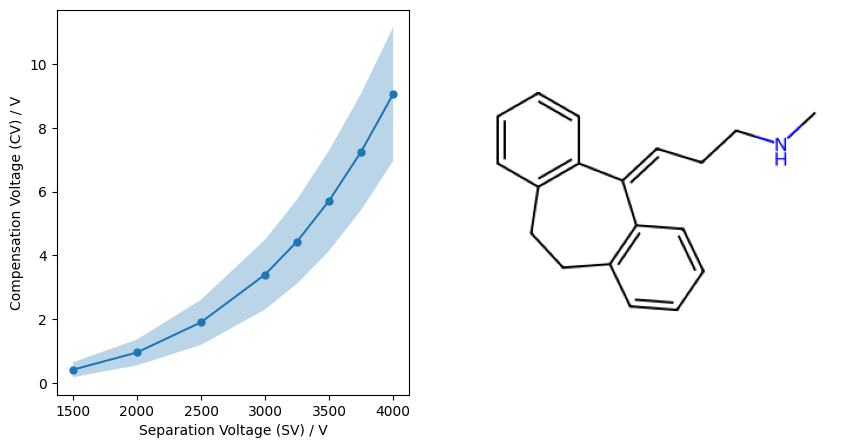

Error Table for Compound: CNCCC=C1c2c(cccc2)CCc2c1cccc2
+---------------------------------------------+--------+--------+--------+--------+--------+--------+--------+--------+
| Separation Voltage (SV)                     |   1500 |   2000 |   2500 |   3000 |   3250 |   3500 |   3750 |   4000 |
+=============================================+========+========+========+========+========+========+========+========+
| Average Predicted CV / V                    |    0.4 |    1   |    1.9 |    3.4 |    4.4 |    5.7 |    7.2 |    9.1 |
+---------------------------------------------+--------+--------+--------+--------+--------+--------+--------+--------+
| Average (Solvent + Dispersion Type) MAE / V |    0.2 |    0.4 |    0.7 |    1.1 |    1.3 |    1.6 |    1.8 |    2.1 |
+---------------------------------------------+--------+--------+--------+--------+--------+--------+--------+--------+
| Prediction σ (shuffle folds) / V            |    0   |    0   |    0   |    0   |    0   |    0   |   

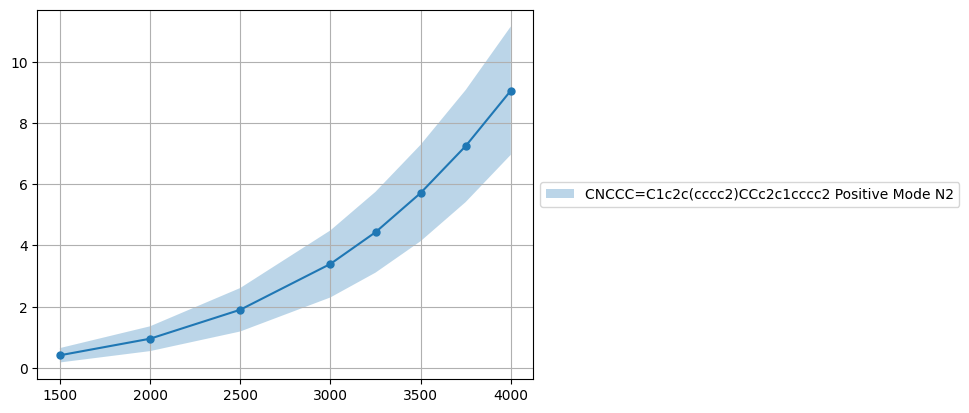

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
#@title Model Predictions and Evaluation (~1 min per seed)

# Utility Functions
def save_to_csv(data, columns, filename):
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(filename, index=False)
    files.download(filename)

def save_predictions(SMILES_column, predicted_CV, descriptors, predictions_flag, descriptors_flag, job_name,):
    if predictions_flag:
        predicted_df = pd.DataFrame(predicted_CV, columns=["1500", "2000", "2500", "3000", "3250", "3500", "3750", "4000"])
        result_frame = pd.concat([SMILES_column, predicted_df], axis=1)
        save_to_csv(result_frame, None, f"{job_name}_ Predictions_data.csv")

    if descriptors_flag:
        save_to_csv(descriptors, None, f"{job_name}_Calculated_descriptors.csv")

def determine_behavior_type(predictions):
    if all(predictions[i] > predictions[i + 1] for i in range(len(predictions) - 1)):
        return "Type A"
    elif all(predictions[i] < predictions[i + 1] for i in range(len(predictions) - 1)):
        return "Type C"
    return "Type B"

def calculate_error_bars(MS_Mode, DMS_Environment, predictions):
    error_matrix = [[0.22, 0.57, 0.5, 0.49, 0.25, 0.38, 0.39], [0.37, 1.17, 1.01, 0.98, 0.44, 0.69, 0.85],
                    [0.62, 2.04, 1.73, 1.63, 0.8, 1.18, 1.47], [0.94, 3.07, 2.59, 2.42, 1.25, 1.76, 2.26],
                    [1.13, 3.64, 3.04, 2.88, 1.51, 2.11, 2.66], [1.34, 4.38, 3.67, 3.46, 1.81, 2.58, 3.12],
                    [1.56, 5.34, 4.58, 4.12, 2.1, 3.16, 3.67], [1.79, 6.55, 5.74, 4.94, 2.4, 3.88, 4.33]]

    error_df = pd.DataFrame(error_matrix, columns=["N2", "MeOH", "Type A", "Type B", "Type C", "Positive Mode", "Negative Mode"])
    behavior_type = determine_behavior_type(predictions)
    errors = (error_df[behavior_type] + error_df[DMS_Environment]) / 2 # + error_df[MS_Mode]
    return errors.tolist()

def plot_results(predictions, compound_names, MS_Mode, DMS_Environment, save_plots, std_dev):
    x_vals = [1500, 2000, 2500, 3000, 3250, 3500, 3750, 4000]

    for idx, compound in enumerate(compound_names):
        molecule = Chem.MolFromSmiles(compound)
        img = Draw.MolToImage(molecule)
        errors = calculate_error_bars(MS_Mode, DMS_Environment, predictions[idx])

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].plot(x_vals, predictions[idx], 'o-', markersize = 5)
        ax[0].fill_between(x_vals, np.array(predictions[idx]) - np.array(errors),
                           np.array(predictions[idx]) + np.array(errors), alpha=0.3)
        ax[0].set_xlabel("Separation Voltage (SV) / V")
        ax[0].set_ylabel("Compensation Voltage (CV) / V")

        ax[1].imshow(img)
        ax[1].axis("off")

        # if save_plots:
        #     plot_file = f"{compound}_plot.jpg"
        #     plt.savefig(plot_file)
        #     files.download(plot_file)

        plt.show()
        plt.clf()
        print(f"Error Table for Compound: {compound}")
        print_error_table(list(predictions[idx]), errors, std_dev[idx])
    for idx, compound in enumerate(compound_names):

        p_label = compound + " " + MS_Mode + " " + DMS_Environment
        plt.plot(x_vals, predictions[idx], 'o-', markersize = 5)

        plt.fill_between(x_vals, np.array(predictions[idx]) - np.array(errors),
                        np.array(predictions[idx]) + np.array(errors), alpha=0.3, label=p_label)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    plt.show()
    plt.clf()

def check_database(smiles_list, db_smiles):
    return [smiles in db_smiles for smiles in smiles_list]

def print_error_table(predictions, errors, std):
    header = ["Separation Voltage (SV)", "1500", "2000", "2500", "3000", "3250", "3500", "3750", "4000"]
    table = [
        ["Average Predicted CV / V"] + [round(p, 1) for p in predictions],
        ["Average (Solvent + Dispersion Type) MAE / V"] + [round(e, 1) for e in errors],
        ['Prediction σ (shuffle folds) / V'] + [round(e, 1) for e in std]]
    #     ["Prediction - Error"] + [round(p - e, 1) for p, e in zip(predictions, errors)],
    #     ["Prediction + Error"] + [round(p + e, 1) for p, e in zip(predictions, errors)]
    # ]
    print(tabulate(table, headers=header, tablefmt="grid"))

# Model Evaluation
def evaluate_rf_model(model, descriptors, DMS_Environment, MS_Mode, precomputed_data_path, results_frame, seed_values, save_plots, job_name,):
    total_preds = []
    for desc in tqdm(descriptors):
      precomputed_data = pd.read_csv(precomputed_data_path)
      target_data = results_frame.copy()

      # Add environmental data
      target_data["Positive?"] = 0 if MS_Mode == "Positive Mode" else 1
      target_data["Modifier"] = 0 if DMS_Environment == "N2" else 1

      in_database = check_database(target_data["SMILES"].values, precomputed_data["ProcessedSMILES"].values)
      # print("Database Matches:", in_database) ## TODO: you need to figure out if the SMILES is in the dataset in the modified condition

      # Prepare data
      target_features = target_data[desc]
      # print(target_features[target_features == 'Broken'].count().sum())
      target_features.replace('Broken', np.nan, inplace=True) ## This doesn't appear to have a big impact on results but need to investigate more. TODO

      training_features = precomputed_data[desc]
      training_targets = precomputed_data[["1500", "2000", "2500", "3000", "3250", "3500", "3750", "4000"]]

      model.set_params(random_state=22)
      model.fit(training_features, training_targets)
      predictions = model.predict(target_features)
      total_preds.append(predictions)
          # Generate plots and save predictions
    total_preds = np.asarray(total_preds)
    predictions = np.average(total_preds, axis=0)
    std_dev = np.std(total_preds, axis=0)


    plot_results(predictions, results_frame["SMILES"].values, MS_Mode, DMS_Environment, False, std_dev)
    if save_plots:
      save_predictions(results_frame["SMILES"], predictions, target_data, True, False, job_name)

# Constants
rf_model = RandomForestRegressor(n_estimators=700, min_samples_split=2, min_samples_leaf=2, criterion='squared_error', bootstrap=True)
descriptors_to_use = ['Modifier', 'Chi2v', 'Chi3v', 'WPath', 'AATSC0pe', 'MID_C', 'NdssSe', 'BCUT2D_MRHI', 'ATSC1p', 'C3SP3', 'SpDiam_Dzp', 'n10FHRing', 'piPC2', 'TIC1', 'GATS7pe', 'SlogP_VSA2', 'SZ', 'ETA_dPsi_A', 'BCUTi-1l', 'fr_N_O', 'fr_COO', 'fr_benzene', 'Positive?', 'NssssC', 'SpMAD_D', 'SLogP', 'CIC1', 'fr_NH0', 'MPC10', 'BCUTdv-1l', 'AXp-5dv', 'Xch-3dv', 'MinAbsPartialCharge', 'ETA_eta_R', 'fr_urea', 'AATSC0c', 'fr_thiophene', 'ETA_dEpsilon_B', 'n8Ring', 'EState_VSA4', 'NumAromaticRings', 'AATSC0m', 'GATS2p', 'ETA_epsilon_4', 'NumAliphaticHeterocycles', 'AATS2i', 'SlogP_VSA6', 'ETA_epsilon_3', 'MPC3', 'SM1_Dzare', 'NsBr', 'SIC5', 'MolLogP', 'MATS4se', 'fr_Ar_NH', 'NaaCH', 'Kappa1', 'NaasC', 'SpMAD_Dzv', 'Zagreb2', 'BCUTpe-1h', 'JGI5', 'fr_C_S', 'NaaNH', 'C1SP2', 'NssNH2', 'AMID_h', 'GATS2s', 'SsNH3', 'ATSC3pe', 'fr_dihydropyridine', 'ATSC2c', 'nFAHRing', 'n7HRing', 'ZMIC0', 'fr_piperdine', 'amideB', 'AATS1i', 'fr_aryl_methyl', 'MID_O', 'NsNH3', 'BCUT2D_MRLOW', 'AATS7i', 'n7FRing', 'SsOH', 'BIC0', 'MID_N', 'fr_Imine', 'fr_Al_COO', 'HybRatio', 'ATS4m', 'fr_ester', 'AATS7pe', 'SMR_VSA3', 'GATS2m', 'BCUTs-1l', 'JGI4', 'nG12ARing', 'nAHRing', 'SRW06', 'AXp-7dv', 'nG12FARing', 'GATS1se', 'NssssN', 'NsSH', 'AMID_C', 'nBase', 'AATSC0se', 'BCUTm-1h', 'ATS2d', 'SRW10', 'NdNH']
d2 = ['Modifier', 'ATSC8c', 'CIC1', 'AMID_X', 'SlogP_VSA6', 'VR2_Dzare', 'AATSC8d', 'NumRadicalElectrons', 'SaaS', 'NssNH', 'ATSC2m', 'ATS4p', 'GATS1se', 'ATS7v', 'EState_VSA10', 'n10FHRing', 'BCUTp-1h', 'ATS1s', 'RingCount', 'PEOE_VSA1', 'AATSC4v', 'n11FaHRing', 'TopoPSA(NO)', 'AATSC3m', 'n8FAHRing', 'SRW07', 'MATS1pe', 'JGT10', 'ATS5i', 'Xpc-5d', 'AATSC6p', 'SpAD_Dzp', 'NaaN', 'n6FRing', 'BCUTm-1h', 'BCUTZ-1h', 'SMR_VSA10', 'SsssSnH', 'BCUT2D_MWHI', 'MaxPartialCharge', 'AATS7Z', 'FractionCSP3', 'ATS0i', 'MDEC-23', 'BCUTse-1h', 'SlogP_VSA8', 'NsssdAs', 'n8FaRing', 'ATSC6are', 'GATS3Z', 'n12ARing', 'VSA_EState6', 'ATS1d', 'ATS0v', 'ATSC6s', 'AATSC0s', 'Mpe', 'AATSC5c', 'SM1_Dzv', 'NssBe', 'SM1_Dzi', 'NsssSiH', 'SdCH2', 'SsssN', 'n7FHRing', 'NumSaturatedHeterocycles', 'SM1_DzZ', 'nS', 'SaaSe', 'AATSC0pe', 'mZagreb1', 'AATSC4dv', 'BCUT2D_MRLOW', 'SsssCH', 'SsOH', 'n7FaRing', 'n12HRing', 'TIC1', 'AATS1i', 'fr_Al_OH_noTert', 'AATSC0m', 'Sm', 'SpMAD_Dzv', 'AATS1s', 'ATS0se', 'SMR_VSA1', 'NsssSnH', 'EState_VSA8', 'nBondsM', 'GATS2p', 'MID_N', 'VE3_D', 'NddsN', 'NsSiH3', 'MATS6dv', 'VE1_Dzp', 'EState_VSA11', 'VSA_EState9', 'SsPbH3', 'SIC2', 'c_ar', 'SsF', 'GATS2s', 'NsssP', 'MATS1d', 'n9FAHRing', 'NumSaturatedCarbocycles', 'Kappa3', 'SMR_VSA6', 'NsssN', 'LabuteASA', 'NssS', 'Kappa1', 'MATS2i', 'ATS0p', 'MID_O', 'SaasC', 'nAromBond', 'SMR_VSA3', 'Positive?', 'nAromAtom', 'NsssB', 'NdNH', 'Mare', 'AMID_C', 'AATS2dv', 'JGI4', 'fr_N_O', 'ATSC3pe', 'fr_Ndealkylation1', 'GATS4s', 'BCUTc-1h', 'nBase', 'PEOE_VSA14', 'NssO', 'ATSC0s', 'MATS2c', 'SpDiam_Dzare', 'AATS2Z', 'SpMAD_Dzse']
d3 = ['Modifier', 'SpAbs_Dzi', 'MATS3c', 'MATS1p', 'GATS4v', 'GATS1Z', 'BCUTc-1h', 'AATSC6s', 'GATS5i', 'VR1_Dzm', 'GATS2c', 'apol', 'ATS1d', 'SssS', 'piPC2', 'NssAsH', 'AETA_eta_R', 'AATS4pe', 'n6FaHRing', 'Vabc', 'SIC3', 'AATS4m', 'n8FARing', 'SMR_VSA7', 'SdS', 'PEOE_VSA1', 'ETA_eta_B', 'SMR_VSA4', 'RPCG', 'ATS1p', 'BertzCT', 'fr_Ndealkylation2', 'BCUT2D_LOGPLOW', 'MATS1i', 'FilterItLogS', 'SsssN', 'GATS2v', 'AATS0Z', 'BCUTse-1l', 'MATS3pe', 'SssPH', 'ATSC6m', 'LabuteASA', 'NsOH', 'n5Ring', 'n5FRing', 'AATS1v', 'AATSC2i', 'fr_Imine', 'ATSC0c', 'GATS1pe', 'BCUTse-1h', 'C3SP3', 'MWC04', 'MATS2i', 'ATS1Z', 'fr_COO2', 'nBridgehead', 'NaaaC', 'SMR_VSA3', 'VE2_D', 'AATS8dv', 'PEOE_VSA13', 'BCUTdv-1l', 'SpAD_DzZ', 'fr_NH0', 'HybRatio', 'SsF', 'MPC3', 'nBase', 'AATSC0pe', 'SsOH', 'SpMax_Dzm', 'ETA_dAlpha_B', 'VSA_EState9', 'NsssSiH', 'JGI4', 'AETA_eta_RL', 'MaxAbsPartialCharge', 'NsCH3', 'nBondsO', 'ETA_dAlpha_A', 'AXp-7dv', 'BCUTv-1l', 'JGI5', 'VE3_Dzp', 'SdsN', 'EState_VSA9', 'MIC4', 'AATSC0s', 'amideB', 'AXp-0dv', 'AATSC1pe', 'NumValenceElectrons', 'SlogP_VSA2', 'NssssBe', 'AATS5p', 'JGI6', 'NaaS', 'AATS8pe', 'fr_lactone', 'Positive?', 'SpMAD_Dzp', 'AATS1d', 'fr_amidine', 'GATS2p', 'MATS4s', 'RingCount', 'GATS2Z', 'GATS2s', 'SpAD_Dzse', 'ATS0p', 'nBondsD', 'fr_sulfonamd', 'piPC10', 'n11FARing', 'MATS4se', 'GGI10', 'LogEE_DzZ', 'n10FaRing', 'SM1_DzZ', 'ETA_dEpsilon_A', 'nN', 'VE1_Dzp', 'ATS7Z']
d4 = ['Modifier', 'WPath', 'SRW09', 'AATSC0pe', 'MID_C', 'NdssSe', 'ATS6d', 'nF', 'BCUT2D_MRHI', 'ATSC1p', 'C3SP3', 'VE1_A', 'SpDiam_Dzp', 'n12ARing', 'AATSC5v', 'TPSA', 'SssPH', 'piPC2', 'TIC1', 'GATS7pe', 'SlogP_VSA2', 'SZ', 'BCUTi-1l', 'fr_N_O', 'fr_COO', 'fr_benzene', 'Positive?', 'nAromBond', 'fr_NH0', 'BCUTdv-1l', 'Xp-2d', 'MinAbsPartialCharge', 'ETA_eta_R', 'NsSiH3', 'AXp-6dv', 'AATSC0c', 'fr_thiophene', 'C3SP2', 'MWC01', 'n9FHRing', 'Mse', 'NsGeH3', 'ETA_dEpsilon_B', 'EState_VSA4', 'Xch-6d', 'AATSC0m', 'nG12FaHRing', 'GATS2p', 'AATSC0p', 'ETA_epsilon_4', 'NumAliphaticHeterocycles', 'AATS2i', 'SlogP_VSA6', 'ETA_epsilon_3', 'ATSC3c', 'n5Ring', 'MATS4se', 'n7FHRing', 'BCUTi-1h', 'ATSC1Z', 'n9aRing', 'Kappa1', 'NaasC', 'AXp-0dv', 'AATSC0are', 'nBondsO', 'ETA_dEpsilon_A', 'n5FARing', 'GATS2s', 'SM1_Dzse', 'SsNH3', 'n5aHRing', 'fr_diazo', 'SaaCH', 'ZMIC0', 'n8FaHRing', 'NdssS', 'n6ARing', 'AATS7se', 'Kier1', 'nG12FaRing', 'NaaN', 'ETA_dBeta', 'SaaNH', 'Mp', 'fr_azo', 'EState_VSA9', 'fr_ether', 'SMR_VSA3', 'nG12FAHRing', 'GATS2m', 'RotRatio', 'SM1_Dzv', 'MaxPartialCharge', 'MIC2', 'JGI4', 'nAHRing', 'AXp-7dv', 'SpMAD_A', 'AATSC4c', 'NsOH', 'SsSnH3', 'SdsssP', 'nBase', 'nN', 'SM1_DzZ', 'nG12FRing', 'AATSC3pe', 'nBondsD', 'BCUT2D_MWHI', 'SIC0', 'SssS', 'fr_para_hydroxylation', 'fr_benzodiazepine', 'Mi', 'NsPbH3']
d5 = ['Modifier', 'ATS4Z', 'LogEE_Dzm', 'fr_thiophene', 'fragCpx', 'GATS5s', 'fr_Ndealkylation2', 'EState_VSA1', 'ATSC1c', 'BCUTpe-1h', 'NumAromaticCarbocycles', 'ATS6se', 'SMR_VSA9', 'BCUTc-1h', 'Kappa3', 'TIC3', 'NumHAcceptors', 'ATSC2pe', 'nX', 'naRing', 'fr_nitro', 'ETA_eta_BR', 'VR3_A', 'ATS2se', 'SlogP_VSA1', 'NssNH2', 'ATS8v', 'fr_methoxy', 'RNCG', 'MinAbsPartialCharge', 'ETA_shape_y', 'nBase', 'AATS0pe', 'Xc-3d', 'nFaHRing', 'LogEE_A', 'ATS4dv', 'AATS1p', 'GATS1s', 'n9HRing', 'MDEC-23', 'piPC6', 'JGI4', 'NsssssAs', 'MATS2s', 'fr_C_O_noCOO', 'ATS1m', 'AMID_N', 'n11FRing', 'GATS1m', 'AMID_h', 'nFHRing', 'GATS1are', 'EState_VSA8', 'ATSC5v', 'VSA_EState9', 'AATS2d', 'ATSC7dv', 'nO', 'AATSC0se', 'NumAliphaticHeterocycles', 'NHOHCount', 'SsssssAs', 'SssS', 'fr_COO2', 'AATSC0are', 'SdsCH', 'SsCH3', 'SMR_VSA7', 'MID', 'SsssN', 'ATSC1i', 'NsssNH', 'MATS1pe', 'SpAbs_Dzm', 'ATSC3pe', 'MID_N', 'Xp-7d', 'ATS4m', 'fr_barbitur', 'SpMax_Dzpe', 'ETA_dBeta', 'MinEStateIndex', 'ATSC2c', 'SpDiam_Dzm', 'GATS1Z', 'AATS0Z', 'ATS8dv', 'GATS1pe', 'NsOH', 'SpMAD_Dzp', 'NsBr', 'n5ARing', 'ATSC2s', 'fr_C_S', 'VSA_EState1', 'n7ARing', 'BCUTp-1l', 'GATS2s', 'BCUTi-1l', 'VR1_Dzm', 'n8Ring', 'LogEE_Dzpe', 'n6aHRing', 'MinPartialCharge', 'ETA_beta_ns_d', 'fr_hdrzone', 'TIC1', 'NssBH', 'SM1_Dzv', 'Xch-6d', 'FilterItLogS', 'SpMAD_Dzv', 'MATS1Z', 'AATS8pe', 'SlogP_VSA2', 'AATS2Z', 'AATS0s', 'n9FARing', 'nF', 'ATS8i', 'SMR_VSA3', 'BCUT2D_MRLOW', 'fr_amide', 'BCUT2D_MRHI', 'NaaSe', 'ATSC1Z', 'GGI1', 'ETA_dEpsilon_A', 'Kier1', 'ATS8pe', 'MATS5p', 'ZMIC0', 'SssPH', 'Zagreb2', 'VSA_EState10', 'BCUT2D_MWHI', 'AATSC6pe', 'Positive?', 'SRW04', 'GATS2p', 'n12ARing', 'NsCl', 'SMR_VSA10', 'SdCH2', 'VR3_Dzm', 'AATSC1p', 'ETA_epsilon_1', 'fr_C_O', 'PEOE_VSA13', 'nSpiro', 'GATS2are']
d6 = ['Modifier', 'SlogP_VSA1', 'ATSC7d', 'nHBAcc', 'ATSC8pe', 'SlogP_VSA8', 'AATS1p', 'GATS2se', 'n9FHRing', 'fr_alkyl_halide', 'n5aRing', 'BCUTpe-1h', 'MATS8c', 'ETA_dEpsilon_B', 'Mm', 'MDEC-22', 'fr_thiocyan', 'piPC3', 'C3SP3', 'MIC5', 'MinAbsPartialCharge', 'NsAsH2', 'MWC03', 'AATS1Z', 'n4FaHRing', 'n5AHRing', 'NsOH', 'SsSiH3', 'VR2_Dzpe', 'ATS4v', 'ETA_epsilon_3', 'nG12Ring', 'Diameter', 'n6HRing', 'ATSC0c', 'MPC10', 'ATS8dv', 'AXp-5d', 'n9FRing', 'Kier1', 'SssssN', 'C3SP2', 'ATS1Z', 'MinPartialCharge', 'SssssSn', 'MolWt', 'Xc-6d', 'ATSC3c', 'n7AHRing', 'MID_h', 'SM1_Dzv', 'fr_halogen', 'ATS3se', 'AATSC1i', 'SsNH2', 'AATSC0dv', 'nG12FAHRing', 'AATSC5p', 'nRing', 'Xch-5d', 'StCH', 'AXp-0dv', 'ATS6se', 'fr_C_S', 'SsssAs', 'Xch-5dv', 'GATS2are', 'fr_tetrazole', 'AMID_N', 'AATSC6dv', 'n9FAHRing', 'NdssSe', 'nAtom', 'SssNH2', 'AETA_dBeta', 'AATS2m', 'fr_bicyclic', 'ATS2d', 'AATSC0are', 'nG12FRing', 'BCUT2D_MRHI', 'fr_C_O_noCOO', 'n6Ring', 'MATS1pe', 'SlogP_VSA10', 'n3ARing', 'AATSC6se', 'SaaSe', 'fr_sulfide', 'Xp-3d', 'SM1_Dzm', 'ATS6Z', 'SssSe', 'MATS1d', 'GATS2Z', 'GGI3', 'n7FaRing', 'SMR_VSA10', 'ATS0v', 'SpDiam_Dzp', 'MPC5', 'NssS', 'BCUTi-1h', 'VR2_D', 'MaxAbsPartialCharge', 'NaasC', 'nBondsD', 'SsOH', 'MATS2i', 'n7FaHRing', 'nBase', 'Spe', 'Chi1', 'ATS8p', 'SsssPbH', 'NumAromaticCarbocycles', 'MID_O', 'VE2_Dzse', 'n5Ring', 'ETA_epsilon_1', 'fr_NH0', 'AATS0i', 'AATSC3pe', 'NssssPb', 'n9aRing', 'Positive?', 'NsLi', 'NsSiH3', 'LabuteASA', 'AATS7p', 'fr_prisulfonamd', 'AATS0s', 'nCl', 'AETA_beta', 'piPC5', 'SdsCH', 'SssssB', 'ATSC1m', 'n4AHRing', 'Sse', 'ZMIC0', 'SMR_VSA9', 'n10AHRing', 'GATS2s', 'n4FRing', 'GATS1se', 'fr_Ar_N', 'ETA_alpha', 'NaaN', 'Kappa1', 'SM1_DzZ', 'ATS8s', 'NaasN', 'fr_nitro', 'GATS2p', 'SMR_VSA3', 'oh_count', 'ATSC3pe', 'SlogP_VSA2', 'ETA_dBeta', 'NssBe', 'NtsC', 'fr_ketone_Topliss']
d7 = ['Modifier', 'ATS2p', 'SpMAD_A', 'ATS6se', 'SsSH', 'ATSC5are', 'ATSC1d', 'AATSC0Z', 'BCUTare-1h', 'AATS3m', 'NumAromaticCarbocycles', 'ABC', 'GATS4dv', 'NsOH', 'NdS', 'SpDiam_Dzm', 'Mv', 'PEOE_VSA1', 'fr_Al_OH', 'Xc-3d', 'NsssCH', 'MID_O', 'a_prop', 'MinAbsPartialCharge', 'MATS6pe', 'AATS2pe', 'SsssssP', 'AATS4i', 'oh_count', 'fr_unbrch_alkane', 'fMF', 'SsssAs', 'SsssN', 'ETA_dEpsilon_B', 'AATS1m', 'BCUTZ-1h', 'ATS3Z', 'AATSC3are', 'n9Ring', 'NtN', 'PEOE_VSA12', 'MATS2are', 'nAromBond', 'MATS1Z', 'ATS1p', 'ATSC0m', 'C1SP2', 'SsBr', 'MATS3pe', 'AATS0d', 'EState_VSA9', 'GATS3Z', 'BCUT2D_MRHI', 'AATS2m', 'fr_urea', 'SpDiam_Dzse', 'GATS1se', 'C2SP1', 'HybRatio', 'BCUTi-1l', 'GATS1dv', 'AATS2i', 'MATS1pe', 'AETA_beta_ns_d', 'SlogP_VSA8', 'AATS7i', 'fr_dihydropyridine', 'BCUTm-1h', 'nAcid', 'fr_phenol', 'SMR_VSA3', 'MPC9', 'ATSC4c', 'ATSC4are', 'AXp-7dv', 'FCSP3', 'AATSC7i', 'n5FARing', 'MID_N', 'BCUT2D_MWHI', 'MATS1d', 'GGI10', 'fr_ketone_Topliss', 'nG12FARing', 'Positive?', 'AATS6p', 'SM1_Dzm', 'NssSiH2', 'ATSC2s', 'AATSC0s', 'ATSC6Z', 'ETA_eta_B', 'fr_Ar_COO', 'SaaN', 'PEOE_VSA6', 'Kappa1', 'qed', 'ATSC6m', 'SssBH', 'GATS2Z', 'SlogP_VSA2', 'nN', 'GATS2p', 'PEOE_VSA5', 'nBondsKS', 'AATSC7se', 'SpMAD_Dzv', 'NsssGeH', 'ETA_epsilon_4', 'ATS2Z', 'ATSC0Z', 'AATS8se', 'nBase', 'ATSC7dv', 'AATS1p', 'BCUT2D_MRLOW', 'MPC6', 'fr_C_S']
d8 = ['Modifier', 'VR1_A', 'MATS3m', 'PEOE_VSA8', 'ATS4Z', 'nHBDon', 'nHRing', 'n6aRing', 'MATS1Z', 'ATSC2Z', 'SdSe', 'nBonds', 'SRW10', 'SM1_DzZ', 'VSA_EState6', 'Mse', 'NsssssP', 'LogEE_A', 'GATS6c', 'VSA_EState9', 'ETA_epsilon_3', 'MATS7dv', 'nBondsM', 'AMID_O', 'ETA_shape_x', 'AATSC0c', 'AMID_h', 'MaxPartialCharge', 'LogEE_Dzp', 'AATS5se', 'ATSC2se', 'GATS3pe', 'MinAbsPartialCharge', 'fr_Ar_COO', 'AATSC0s', 'n3aHRing', 'SIC5', 'SddsN', 'SM1_Dzm', 'ATS8se', 'ATSC2c', 'GATS8Z', 'GATS2s', 'NaasN', 'ETA_dBeta', 'EState_VSA4', 'GGI9', 'SssPH', 'SlogP_VSA1', 'C2SP3', 'AATS5Z', 'AATSC1i', 'MATS1p', 'BCUTpe-1h', 'ATSC0m', 'SMR_VSA10', 'ATS8p', 'BCUTdv-1l', 'MWC10', 'AATSC5p', 'NaaO', 'NumAromaticRings', 'ATS2m', 'ATSC4dv', 'SlogP_VSA2', 'AATSC0Z', 'fr_phos_acid', 'nBase', 'SssssSi', 'fr_Al_OH_noTert', 'MW', 'nN', 'AATSC7pe', 'SpMAD_Dzm', 'MID_h', 'AATSC1d', 'fr_NH0', 'AATS7i', 'AATS7dv', 'SssBH', 'NaaN', 'NumAromaticCarbocycles', 'EState_VSA11', 'MinPartialCharge', 'nFaRing', 'fr_N_O', 'ATS0p', 'AATS8dv', 'BCUTi-1h', 'AATS2m', 'n4FaHRing', 'ATSC3c', 'n8aHRing', 'n4aRing', 'SM1_Dzse', 'MinEStateIndex', 'NumHeteroatoms', 'SpMAD_Dzv', 'ATSC6dv', 'fr_prisulfonamd', 'MolLogP', 'nFHRing', 'oh_count', 'ATSC0c', 'JGI5', 'SssS', 'fr_Al_COO', 'AATS8s', 'NumHDonors', 'NumValenceElectrons', 'SssssB', 'SpMax_Dzp', 'ETA_epsilon_1', 'EState_VSA6', 'AATS1are', 'GATS2m', 'ZMIC0', 'GATS5m', 'SMR_VSA3', 'SaaN', 'fr_pyridine', 'MATS1pe', 'GGI2', 'EState_VSA5', 'n8FHRing', 'GATS4s', 'VE1_Dzp', 'NaasC', 'Positive?', 'fr_halogen', 'ATS8dv', 'SsOH', 'VE1_Dzse', 'Kappa1', 'ATS2p', 'MolWt', 'fr_methoxy', 'fr_hdrzone', 'ATSC3se']
d9 = ['Modifier', 'ATSC3v', 'fr_ester', 'MATS5s', 'MATS8pe', 'AETA_beta_ns', 'AATS0p', 'nHeavyAtom', 'Positive?', 'NsssSnH', 'VSA_EState8', 'MPC3', 'ATSC1s', 'ATS2se', 'LogEE_D', 'SM1_DzZ', 'SsCH3', 'piPC2', 'GATS8p', 'fr_imide', 'nG12FaHRing', 'C1SP2', 'Kier2', 'naHRing', 'BCUTm-1h', 'AATS1v', 'AMID_C', 'ATSC1i', 'AXp-1d', 'NsSH', 'AATS1d', 'MinPartialCharge', 'AATS8v', 'AATSC0are', 'fr_oxazole', 'AATSC5p', 'n12HRing', 'ATSC2i', 'GATS3m', 'NumSaturatedCarbocycles', 'SsNH2', 'SdsCH', 'AMID', 'SddssSe', 'SlogP_VSA8', 'MID_N', 'n5FAHRing', 'Sare', 'fr_morpholine', 'SsssN', 'NdsssP', 'fr_amide', 'MPC9', 'ATSC7se', 'ATS0v', 'f_count', 'MATS2s', 'ATS4m', 'fr_piperdine', 'ATS7p', 'SssPbH2', 'SMR_VSA4', 'SsBr', 'SsGeH3', 'ATSC2s', 'AATSC0s', 'NsssdAs', 'ATSC1are', 'MID_O', 'n10AHRing', 'SsCl', 'NdsCH', 'MinAbsPartialCharge', 'MolLogP', 'NsssSiH', 'Xp-7dv', 'n9FARing', 'ATSC1Z', 'SMR_VSA6', 'AATSC8pe', 'n12FaHRing', 'NssO', 'nBase', 'Xch-6dv', 'AATS2d', 'SsF', 'n5aHRing', 'ATS8se', 'n9ARing', 'GGI9', 'SsOH', 'fr_hdrzone', 'AATSC4dv', 'C2SP2', 'NdssC', 'PEOE_VSA3', 'cl_count', 'NssCH2', 'n8FRing', 'AATS4are', 'MDEC-23', 'NOCount', 'GATS1pe', 'GhoseFilter', 'ATSC1pe', 'n11FRing', 'HybRatio', 'FCSP3', 'ATS8p', 'n11FAHRing', 'NsssGeH', 'BCUT2D_MRHI', 'NssNH', 'SMR_VSA3', 'n3aRing', 'SdssSe', 'naRing', 'SlogP_VSA6', 'n9FHRing', 'AATS1i', 'BCUTare-1h', 'GATS2s', 'Kappa1', 'Mi', 'NumHAcceptors', 'GATS4v']
d10 = ['Modifier', 'fr_thiocyan', 'MPC5', 'GATS3m', 'AATS7are', 'SpAbs_Dzse', 'AATS0pe', 'AATS0s', 'ATSC0i', 'GATS6are', 'ETA_shape_x', 'SpAbs_D', 'AATS7s', 'VE2_Dzi', 'nI', 'n3ARing', 'ATS5s', 'SlogP_VSA10', 'AATS4d', 'SaaO', 'ATSC0c', 'AATS3Z', 'nAtom', 'SaaCH', 'NssSiH2', 'ATSC4c', 'fr_ArN', 'BCUT2D_MWHI', 'AMID_X', 'SssO', 'AXp-3d', 'fr_piperdine', 'MATS1i', 'SsssssAs', 'ATS5Z', 'SpMAD_Dzp', 'Xp-4d', 'BCUTc-1l', 'ATSC7dv', 'Lipinski', 'AATS3m', 'AATSC2i', 'VSA_EState9', 'LabuteASA', 'SsSnH3', 'GATS2se', 'n8aHRing', 'ETA_eta_BR', 'VSA_EState10', 'AATS4m', 'fr_COO', 'MATS1are', 'MPC8', 'ATS1i', 'AATS8s', 'SM1_DzZ', 'ATS8s', 'nHBAcc', 'NsCH3', 'fr_SH', 'SpMAD_DzZ', 'GATS2pe', 'NsOH', 'MW', 'MATS6c', 'Kier1', 'Mpe', 'GATS1m', 'nN', 'SlogP_VSA2', 'MATS5s', 'AATSC4dv', 'SpAbs_Dzpe', 'PEOE_VSA10', 'ATS0d', 'mZagreb1', 'amideB', 'GGI3', 'AATS8m', 'SMR', 'SdCH2', 'BCUTare-1h', 'VE2_Dzse', 'AXp-1d', 'NumAromaticRings', 'MID_N', 'NsssssP', 'SdssC', 'n11ARing', 'nG12FAHRing', 'MATS1pe', 'MATS2c', 'AATSC0se', 'MinEStateIndex', 'AATSC1i', 'nO', 'GhoseFilter', 'n6aHRing', 'fr_nitro_arom_nonortho', 'NumAromaticCarbocycles', 'nBase', 'SIC1', 'VE1_Dzpe', 'AATS2i', 'SsSiH3', 'fr_C_S', 'TIC2', 'ETA_epsilon_1', 'Positive?', 'GATS2m', 'SpAD_Dzpe', 'fr_methoxy', 'GATS2s', 'ZMIC0', 'SMR_VSA2', 'fr_lactone', 'ATS4m', 'fr_sulfide', 'SdsssP', 'BCUT2D_MRHI', 'VE3_Dzm', 'n9aRing', 'AATSC2p', 'ATSC1are', 'Xp-0d', 'SMR_VSA3', 'BCUTi-1h', 'AATS5s', 'MID_O', 'VR3_D', 'nG12FaRing', 'GATS1pe']

descriptors = [d3,descriptors_to_use, d2, d4, d5, d6, d7, d6, d8, d9]
descriptors = descriptors[:int(num_seeds)]

# Run evaluation
evaluate_rf_model(rf_model, descriptors, DMS_Environment, MS_Mode, "Normalized_Working_Descriptors_-1.csv", results_frame, [20, 21, 22, 23, 25], Predictions_results, job_name)


# <h1 style="text-align: center;">**Uncertainty of Predictions** </h1>


![](https://raw.githubusercontent.com/Haisse/Predicting-Dispersion-Curves-Collab/refs/heads/main/Best%20Model%20Error%20Values.png)

Uncertainties are obtained from this table by using the average value between a given SV for the modifier condition and the dispersion type.

e.g. a point meaured in N2 that is type B at 2000 V will have an error of +/- (0.37 V + 0.98 V) / 2 = 0.68 V. This should be thought of as the average error over our training set and does not account for heteroskedacity.

A long term solution is identify the MAPE across these same conditions (exlcluding near zero values) and use that to eliminate the error scaling from MAE

# **Instructions** <a name="Instructions"></a>

**Quick Start**

Select the environment settings for the predictions from the dropdowns.

**MS_Mode** - positive or negative DMS mode.

**DMS_Environment** - The environment in which compound is analyzed.

**SMILES Input** - Input the molecule's SMILES into the textbox. If inputting multiple SMILES, separate them with a comma.

CC(C)C(CCCN(C)CCC1=CC(=C(C=C1)OC)OC)(C#N)C2=CC(=C(C=C2)OC)OC,CC(C)C(CCCNCCC1=CC(=C(C=C1)OC)OC)(C#N)C2=CC(=C(C=C2)OC)OC

The output will be the behaviour plot for the compound(s).

If an option is selected, the Excel file with the predictions can be downloaded. Additional option exists for downloading the calculated descriptors.

**Changes as of 22/11/2024 since last project update on 26/11/2024**
- Added table printout with values for prediction, error, prediction +/- error. Get Cailum to look it over.
- Added direct download to the computer.
- Added 2D molecular image being plotted side by side with the prediction.

**Ideas**
- Create two separate plotting modes for single molecule vs multiple molecules. Single molecule would have central title, graph on the left and 2D structure on the right.
Multiple molecules would have their SMILES in legend? Forsake the 2D plots?
- For single plots, embed the 2D molecule structure in the plot based on behaviour type? Type A, Top right corner. Type B, Top left corner and Type C, bottom left corner.

**To-Implement order:**

- Build the output plot - Multiple plots on the curve, Label with SMILES. How to make the SMILES labels look good. Or build for single case with 2D structure code? Get 2D molecule structure display code from Cailum and add to the plots.

- Plot multiple smiles on the same plot for comparison (e.g., will they separate?)
- Implement the check that pulls actual data if molecule from database is used.
- Investigate glycine prediction crashing, either replace with placeholder value, most average one, or try changing the model to be a five fold.
- Use tqdm to add a progress bar. Split it between different sections, folds of validation?